# SimuJob Example

In [36]:
import simujob as sj
import numpy as np
import matplotlib.pyplot as plt

### Configure the cluster
make sure you can connect to the cluster via
   
       ssh username@clustername
To set up rsa identification, see for example:
https://docs.id.unibe.ch/ubelix/ubelix-101/login-to-the-cluster

In [37]:
sshremote = 'username@clustername'
sshremote = 'hornung@itpcluster.unibe.ch'

### Simulation details

Specify the details of your simulation.

In this example we use the examplenetcdf.py, that takes three arguments -x, -y -n, -fileout, and stores $o_1$ and $o_2$ in fileout.
$$
 o_1 = \left(\frac{x}{y}\right)^{i n}
 o_2 = \left(\frac{y}{a}\right)^{j n}
$$
for $i \in \{0,1,\ldots 11\}$ and $j \in\{ 0,1,\ldots 9\}$
we will use it to calculate $o_1$ and $o_2$ for $n=1.5$ and all combinations of $x$ and $y$ with
$x \in \{0.1,0.2,\ldots 1\}$ and $y \in\{3,4,5\ldots, 10\}$


In [73]:

launchfiletemplate  = """#!/bin/bash
#!/bin/bash
#SBATCH --mail-type=NONE
#SBATCH --array=1-{nmax}
#SBATCH -e err/%A_%a.err
#SBATCH -o out/%A_%a.out

{argdefstring}
python3 examplenetcdf.py {argstring}
"""
# this is the name of the argument, that tells examplemain.py where to store the resulting data
fileargname = 'fileout'
# if our executable generates 1 or 2 dimensional data, specify the name of the inner dimensions
sj.innerdims=()

Specify the job details:

 - localpath: the location to store jobfiles and simulation output locally, it is created if it doesent exist. 
 - remotepath: the location to store jobfiles and simulation output on the cluster, it is created if it doesent exist. 
    
 - name: name of the job 

 - dependencies: a list of paths to files that are copied into localpath. In this simple exmaple this is just
    examplemain.py. 

 - constargs: a dict of arguments that should be the same for all instances of the job
 
 - arrayargs: a dict of argumentname:list, the job will run over all possible combinations of 
      arguments specifiedhere.

In [74]:
thejob = sj.MatrixJob(  sshremote=sshremote,
                    localpath="/home/manes/temp/testsimujoba/",
                      remotepath="/space1/hornung/clustertest/testsimujoba/",
                      name="x_divided_by_y",
                      dependencies=["examplenetcdf.py"],
                     constargs = {'n':1.5},
                     arrayargs = {'x':np.arange(0.1,1,0.1), 'y':np.arange(3,10,1)},
                     launchfiletemplate= launchfiletemplate,
                     fileargname=fileargname)

In [75]:
thejob.remotejobscriptname

'/space1/hornung/clustertest/testsimujoba/x_divided_by_y.sh'

In [76]:
thejob.create_all_files()

In [77]:
thejob.rsync_here2there()

In [78]:
thejob.submit(extracmds='conda activate py3;')

b'Submitted batch job 95514\n'


Now you can check weather it has completed:

In [94]:
thejob.get_status()

0 out of 63 jobs still running


And weather there wer any errors


In [95]:
thejob.print_errors()

b''


### Retrieve the data

In [96]:
thejob.rsync_there2here()
results = thejob.retrieve_data()

Now we have the results as a handy n-dimensional xarray with named dimensions. 
For postprocessing with another program, we can store the data in a single netcdf file, that can be read
by mathematica, matlab, etc

In [104]:
results.to_netcdf(path='/path/to/save/file.nc')

In [42]:
results['obs1'].sel(i=1)

<xarray.DataArray 'obs1' (x: 9, y: 7)>
array([[0.00608581, 0.00395285, 0.00282843, 0.00215166, 0.00170747,
        0.00139754, 0.00117121],
       [0.01721326, 0.01118034, 0.008     , 0.00608581, 0.00482945,
        0.00395285, 0.00331269],
       [0.03162278, 0.0205396 , 0.01469694, 0.01118034, 0.00887227,
        0.00726184, 0.00608581],
       [0.04868645, 0.03162278, 0.02262742, 0.01721326, 0.01365976,
        0.01118034, 0.00936971],
       [0.06804138, 0.04419417, 0.03162278, 0.02405626, 0.01909009,
        0.015625  , 0.01309457],
       [0.08944272, 0.05809475, 0.04156922, 0.03162278, 0.02509457,
        0.0205396 , 0.01721326],
       [0.11271071, 0.07320775, 0.0523832 , 0.03984925, 0.03162278,
        0.02588285, 0.02169119],
       [0.13770607, 0.08944272, 0.064     , 0.04868645, 0.03863562,
        0.03162278, 0.02650155],
       [0.16431677, 0.10672687, 0.07636753, 0.05809475, 0.04610167,
        0.03773365, 0.03162278]])
Coordinates:
    i        int32 1
  * x        (x) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) int64 3 4 5 6 7 8 9

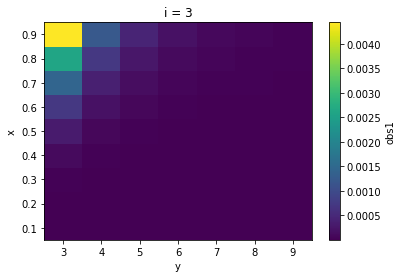

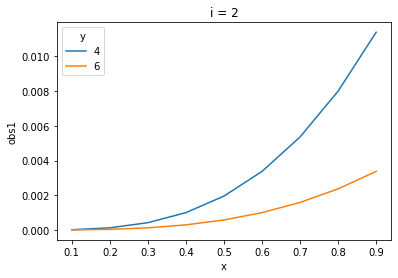

In [103]:
results['obs1'].sel(i=3).plot()
plt.show()
results['obs1'].sel(i=2,y=[4,6]).plot.line(x='x')
plt.show()
#print(results)

In [101]:
results

<xarray.Dataset>
Dimensions:  (i: 12, j: 10, x: 9, y: 7)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9
  * x        (x) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) int64 3 4 5 6 7 8 9
Data variables:
    obs1     (i, x, y) float64 1.0 1.0 1.0 1.0 ... 1.999e-15 2.208e-16 3.162e-17
    obs2     (j, x, y) float64 1.0 1.0 1.0 1.0 ... 1.063e+12 6.448e+12 3.162e+13